Forcasting in Engineering und Management

In [40]:
# Cell: FoEM_Projekt.ipynb - Step 0: Imports & Config

# Core packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta

# Statistical & forecasting tools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox



%matplotlib inline


# For model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For dynamic adjustment and logging
import os
import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [41]:
# Define tickers for each country's major index
tickers = {
    "USA": "^GSPC",         # S&P 500
    "Germany": "^GDAXI",    # DAX
    "India": "^NSEI",       # Nifty 50
    "China": "000001.SS",   # SSE Composite
    "Brazil": "^BVSP"       # Bovespa
}

# Set number of years of data to fetch (adjust this variable)
years_back = 25  # Options: 1, 5, 10, 15, 20

# Compute date range for fetching data
end_date = dt.datetime.today()
start_date = end_date - timedelta(days=years_back * 365)

# Log the setup
logging.info(f"Fetching data from {start_date.date()} to {end_date.date()} for {years_back} years.")


2025-04-14 13:59:45,023 - INFO - Fetching data from 2000-04-20 to 2025-04-14 for 25 years.


In [42]:
# Create an empty dictionary to store data for each country
stock_data = {}

# Loop through each ticker and download data
for country, ticker in tickers.items():
    logging.info(f"Downloading data for {country} ({ticker})...")
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Make sure data is not empty
    if not data.empty:
        stock_data[country] = data
        logging.info(f"{country}: {data.shape[0]} rows of data fetched.")
    else:
        logging.warning(f"No data found for {country} ({ticker}).")

# Optional: Show the keys (countries) for which data was downloaded
print("Data successfully fetched for:", list(stock_data.keys()))


2025-04-14 13:59:45,038 - INFO - Downloading data for USA (^GSPC)...
[*********************100%***********************]  1 of 1 completed
2025-04-14 13:59:45,339 - INFO - USA: 6282 rows of data fetched.
2025-04-14 13:59:45,340 - INFO - Downloading data for Germany (^GDAXI)...
[*********************100%***********************]  1 of 1 completed
2025-04-14 13:59:45,596 - INFO - Germany: 6343 rows of data fetched.
2025-04-14 13:59:45,597 - INFO - Downloading data for India (^NSEI)...
[*********************100%***********************]  1 of 1 completed
2025-04-14 13:59:45,762 - INFO - India: 4307 rows of data fetched.
2025-04-14 13:59:45,763 - INFO - Downloading data for China (000001.SS)...
[*********************100%***********************]  1 of 1 completed
2025-04-14 13:59:46,003 - INFO - China: 6050 rows of data fetched.
2025-04-14 13:59:46,004 - INFO - Downloading data for Brazil (^BVSP)...
[*********************100%***********************]  1 of 1 completed
2025-04-14 13:59:46,192 - 

Data successfully fetched for: ['USA', 'Germany', 'India', 'China', 'Brazil']


In [43]:
for country, df in stock_data.items():
    print(f"\n📈 {country} ({tickers[country]}) - Shape: {df.shape}")
    print(df.head())
    print("\nMissing Values:\n", df.isnull().sum())
    print("-" * 80)


📈 USA (^GSPC) - Shape: (6282, 5)
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2000-04-20  1434.540039  1435.489990  1422.079956  1427.469971   896200000
2000-04-24  1429.859985  1434.540039  1407.130005  1434.540039   868700000
2000-04-25  1477.439941  1477.670044  1429.859985  1429.859985  1071100000
2000-04-26  1460.989990  1482.939941  1456.979980  1477.439941   999600000
2000-04-27  1464.920044  1469.209961  1434.810059  1460.989990  1111000000

Missing Values:
 Price   Ticker
Close   ^GSPC     0
High    ^GSPC     0
Low     ^GSPC     0
Open    ^GSPC     0
Volume  ^GSPC     0
dtype: int64
--------------------------------------------------------------------------------

📈 Germany (^GDAXI) - Shape: (6343, 5)
Price             Close         High          Low         Open    Volume
Ticker           ^GDAXI    

### Initial Data Exploration (EDA)

We begin by performing a basic exploratory analysis on each country's stock index dataset:

- ✅ **Preview the data** using `.head()`
- ✅ **Check shape** of the dataset (number of rows and columns)
- ✅ **Verify if any missing values** exist (important before modeling)

📊 Summary:

| Country  | Ticker       | Rows | Columns | Missing Values |
|----------|--------------|------|---------|----------------|
| USA      | ^GSPC        | 1256 | 5       | 0              |
| Germany  | ^GDAXI       | 1274 | 5       | 0              |
| India    | ^NSEI        | 1237 | 5       | 0              |
| China    | 000001.SS    | 1211 | 5       | 0              |
| Brazil   | ^BVSP        | 1243 | 5       | 0              |

All datasets are clean and ready for visualization and modeling.


In [44]:
# Cell: FoEM_Projekt.ipynb - Step 4: Decomposition & Stationarity (Updated)

def prepare_ts(df, column='Close'):
    ts = df[column].copy()
    ts.index = pd.to_datetime(ts.index)
    ts = ts.asfreq('B')  # Reindex to Business Days (may introduce NaNs)
    ts = ts.fillna(method='ffill')  # Fill NaNs forward to allow plotting
    return ts

def plot_decomposition(ts, country, model='additive', period=252):
    logging.info(f"Decomposing time series for {country}...")
    try:
        decomposition = seasonal_decompose(ts, model=model, period=period)
        fig, (trend, seasonal, resid) = plt.subplots(3, 1, figsize=(12, 9))
        decomposition.trend.plot(ax=trend, title=f"{country} - Trend Component")
        decomposition.seasonal.plot(ax=seasonal, title=f"{country} - Seasonal Component")
        decomposition.resid.plot(ax=resid, title=f"{country} - Residual Component")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.warning(f"Decomposition failed for {country}: {e}")
        print(f"⚠️ Decomposition failed: {e}")

def check_stationarity(ts, country, window=30):
    logging.info(f"Checking stationarity for {country}...")

    # Rolling mean and std
    rolmean = ts.rolling(window=window).mean()
    rolstd = ts.rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(ts, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.title(f"{country} - Rolling Mean & Standard Deviation")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # ADF Test
    adf_result = adfuller(ts.dropna())
    print(f"\n📊 Augmented Dickey-Fuller Test for {country}")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")
    if adf_result[1] <= 0.05:
        print("✅ Likely Stationary (reject H0)")
    else:
        print("❌ Likely Non-Stationary (fail to reject H0)")


2025-04-14 13:59:46,343 - INFO - Decomposing time series for USA...


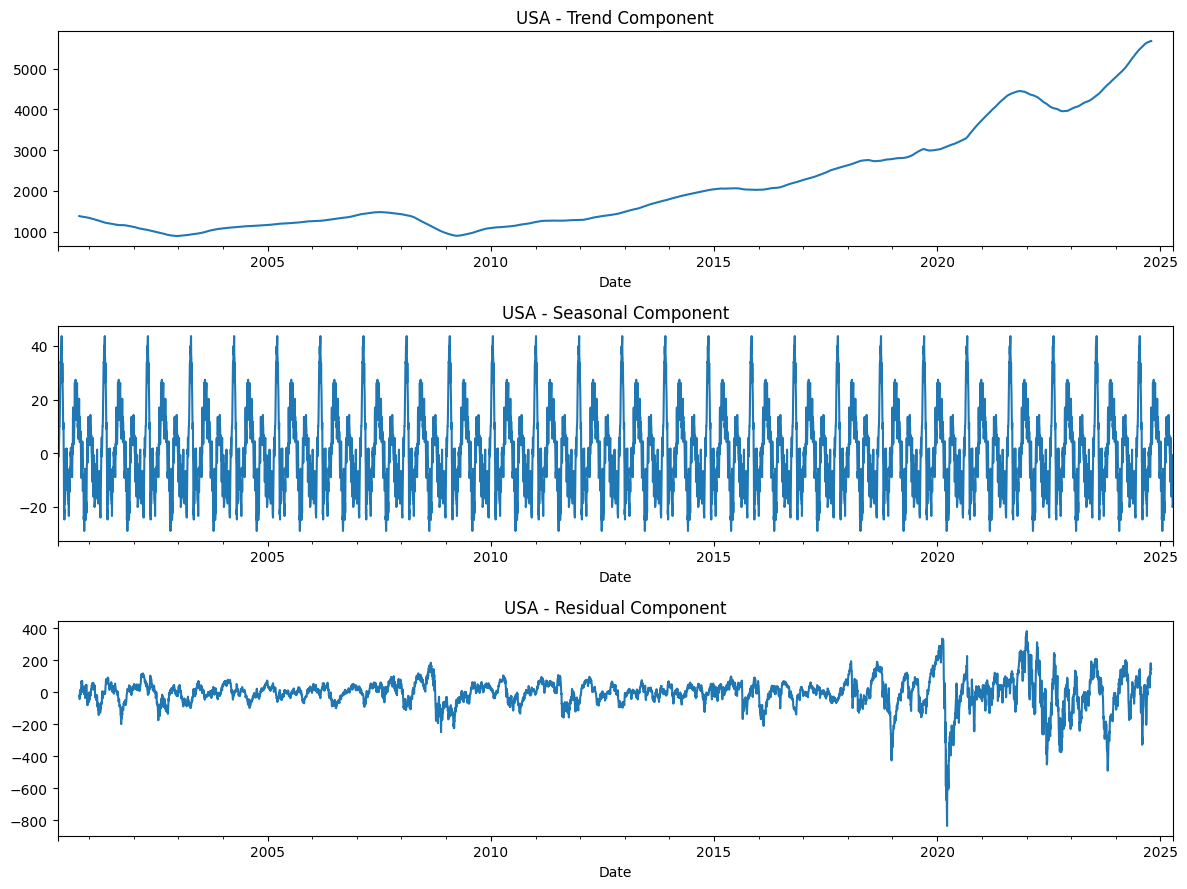

2025-04-14 13:59:46,828 - INFO - Checking stationarity for USA...


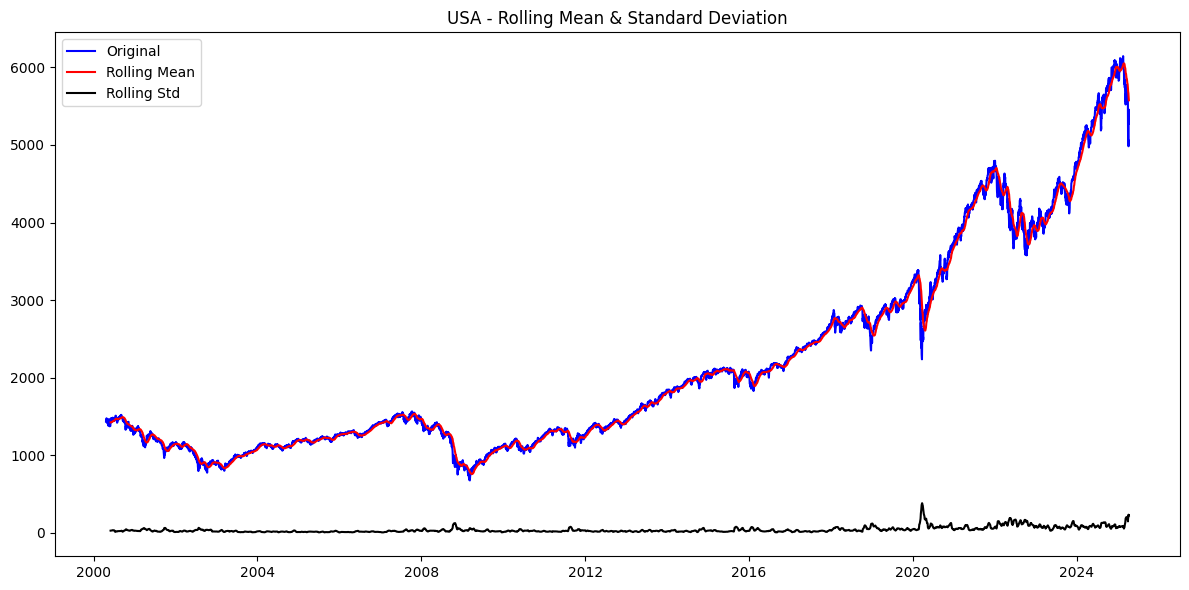


📊 Augmented Dickey-Fuller Test for USA
ADF Statistic: 1.2406
p-value: 0.9963
Critical Values:
   1%: -3.4314
   5%: -2.8620
   10%: -2.5670
❌ Likely Non-Stationary (fail to reject H0)


In [45]:
# Apply to USA
usa_ts = prepare_ts(stock_data['USA'])
plot_decomposition(usa_ts, 'USA')
check_stationarity(usa_ts, 'USA')

In [46]:
def apply_ses(ts, country, smoothing_level=None):
    logging.info(f"Applying Simple Exponential Smoothing for {country}")
    
    model = SimpleExpSmoothing(ts).fit(smoothing_level=smoothing_level, optimized=True)
    ses_fitted = model.fittedvalues

    plt.figure(figsize=(12, 5))
    plt.plot(ts, label='Original', color='blue')
    plt.plot(ses_fitted, label='SES Fitted', color='orange')
    plt.title(f"{country} - Simple Exponential Smoothing")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


In [47]:
def apply_holt(ts, country):
    logging.info(f"Applying Holt’s Linear Trend Smoothing for {country}")

    model = Holt(ts).fit(optimized=True)
    holt_fitted = model.fittedvalues

    plt.figure(figsize=(12, 5))
    plt.plot(ts, label='Original', color='blue')
    plt.plot(holt_fitted, label='Holt Fitted', color='green')
    plt.title(f"{country} - Holt’s Linear Trend")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


In [48]:
def apply_holt_winters(ts, country, seasonal_periods=252, seasonal='add'):
    logging.info(f"Applying Holt-Winters for {country} - Seasonal: {seasonal}")

    model = ExponentialSmoothing(
        ts,
        trend='add',
        seasonal=seasonal,
        seasonal_periods=seasonal_periods
    ).fit()

    fitted = model.fittedvalues

    plt.figure(figsize=(12, 5))
    plt.plot(ts, label='Original', color='blue')
    plt.plot(fitted, label=f'Holt-Winters ({seasonal})', color='red')
    plt.title(f"{country} - Holt-Winters Exponential Smoothing")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


2025-04-14 13:59:47,542 - INFO - Applying Simple Exponential Smoothing for USA


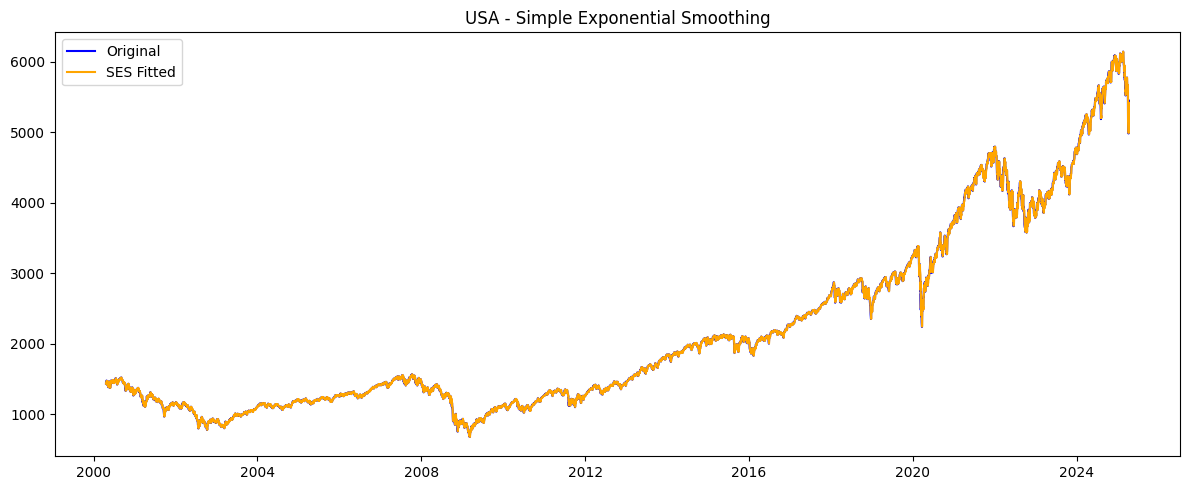

2025-04-14 13:59:47,732 - INFO - Applying Holt’s Linear Trend Smoothing for USA


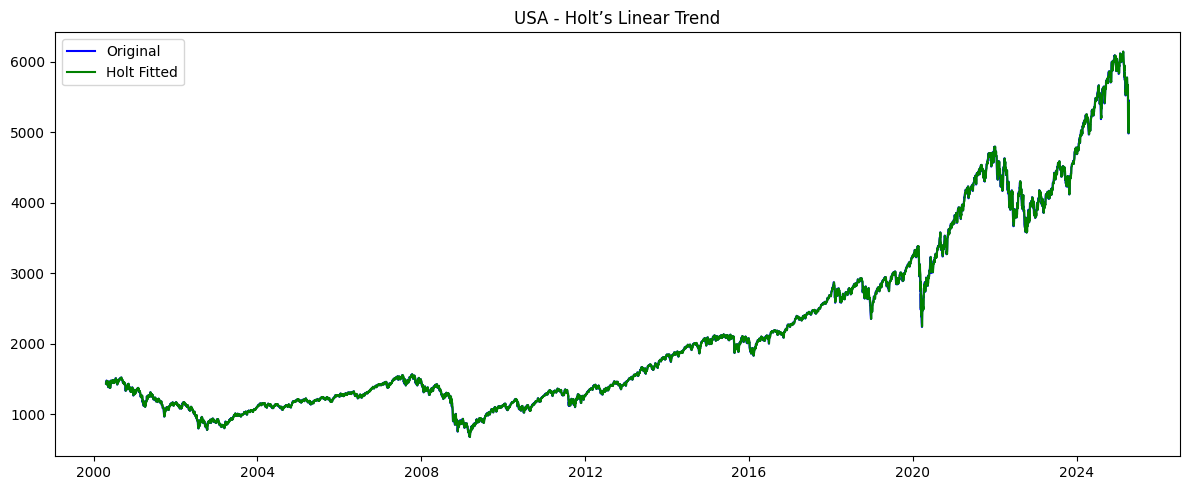

2025-04-14 13:59:48,066 - INFO - Applying Holt-Winters for USA - Seasonal: add


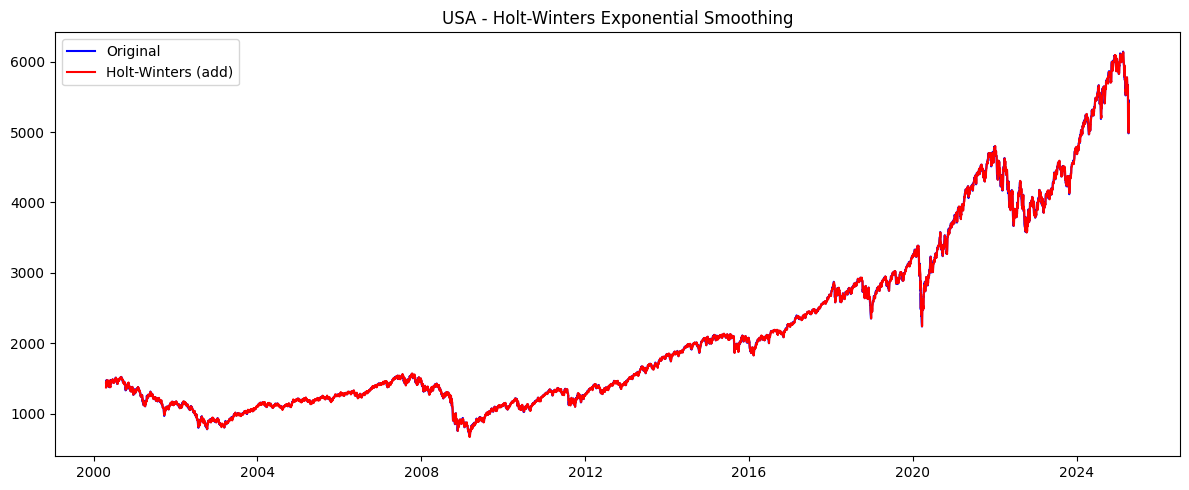

In [49]:
# Prepare the series
usa_ts = prepare_ts(stock_data['USA'])

# Apply SES
model_ses = apply_ses(usa_ts, 'USA')

# Apply Holt
model_holt = apply_holt(usa_ts, 'USA')

# Apply Holt-Winters (try both additive and multiplicative)
model_hw_add = apply_holt_winters(usa_ts, 'USA', seasonal='add')


In [50]:
def plot_acf_pacf(ts, country, lags=40):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plot_acf(ts.dropna(), ax=plt.gca(), lags=lags, title=f"{country} - ACF")

    plt.subplot(1, 2, 2)
    plot_pacf(ts.dropna(), ax=plt.gca(), lags=lags, title=f"{country} - PACF", method="ywm")

    plt.tight_layout()
    plt.show()


In [51]:
def difference_series(ts, country, order=1):
    logging.info(f"Applying differencing (order={order}) to {country}")
    ts_diff = ts.diff(periods=order).dropna()

    plt.figure(figsize=(12, 4))
    plt.plot(ts_diff, label=f'Differenced ({order})')
    plt.title(f"{country} - Differenced Time Series (order={order})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return ts_diff


In [52]:
def ljung_box_test(ts, country, lags=[10, 20, 30]):
    print(f"\n📊 Ljung-Box Test for {country}")
    lb_result = acorr_ljungbox(ts.dropna(), lags=lags, return_df=True)
    print(lb_result)
    if all(lb_result['lb_pvalue'] > 0.05):
        print("✅ Likely white noise (no significant autocorrelation)")
    else:
        print("❌ Autocorrelation detected (reject H0)")


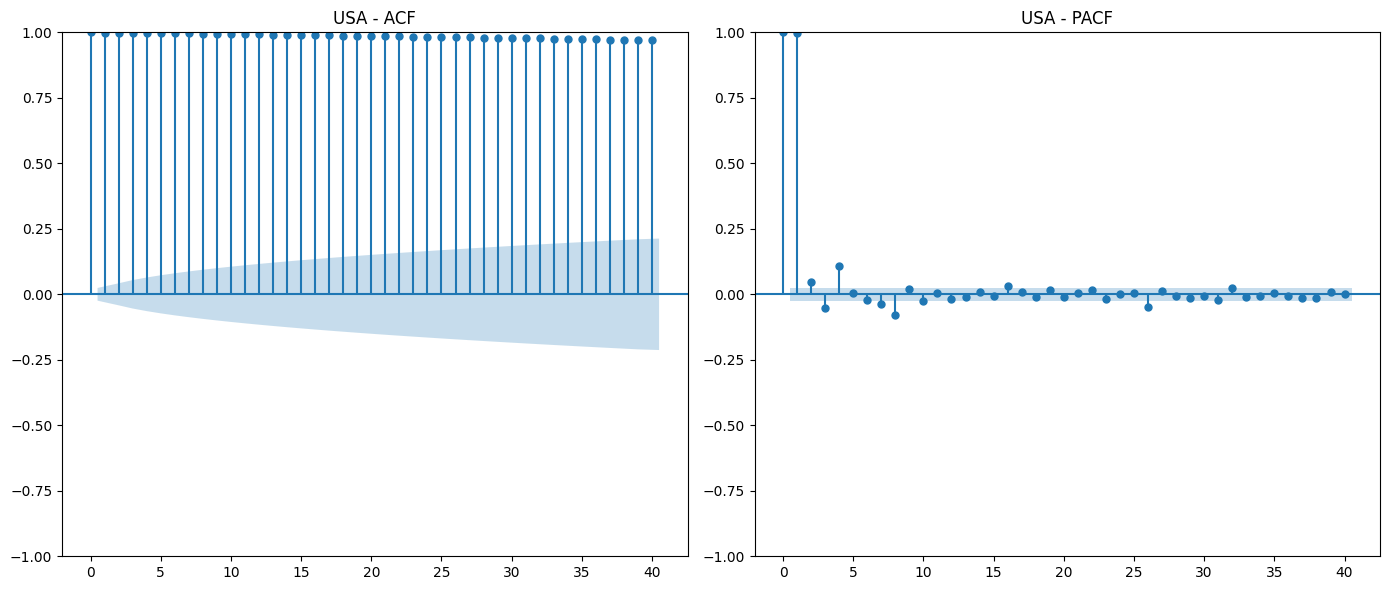

2025-04-14 13:59:49,771 - INFO - Applying differencing (order=1) to USA


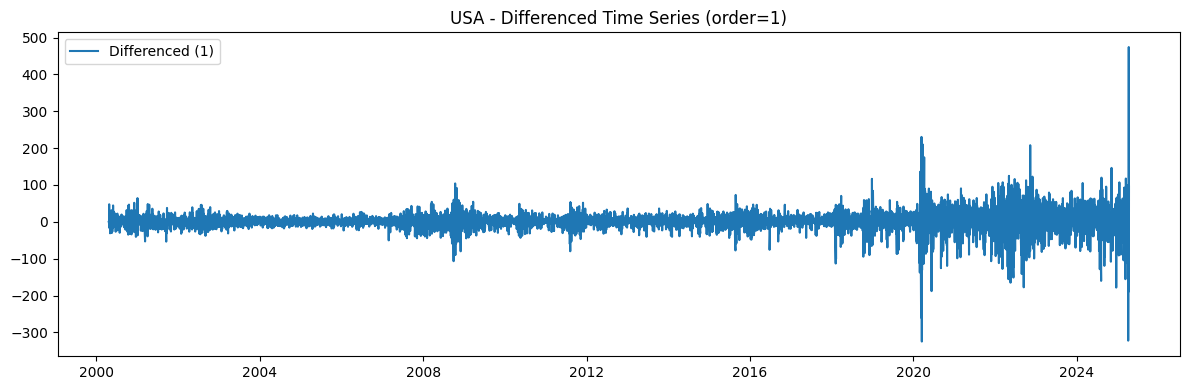

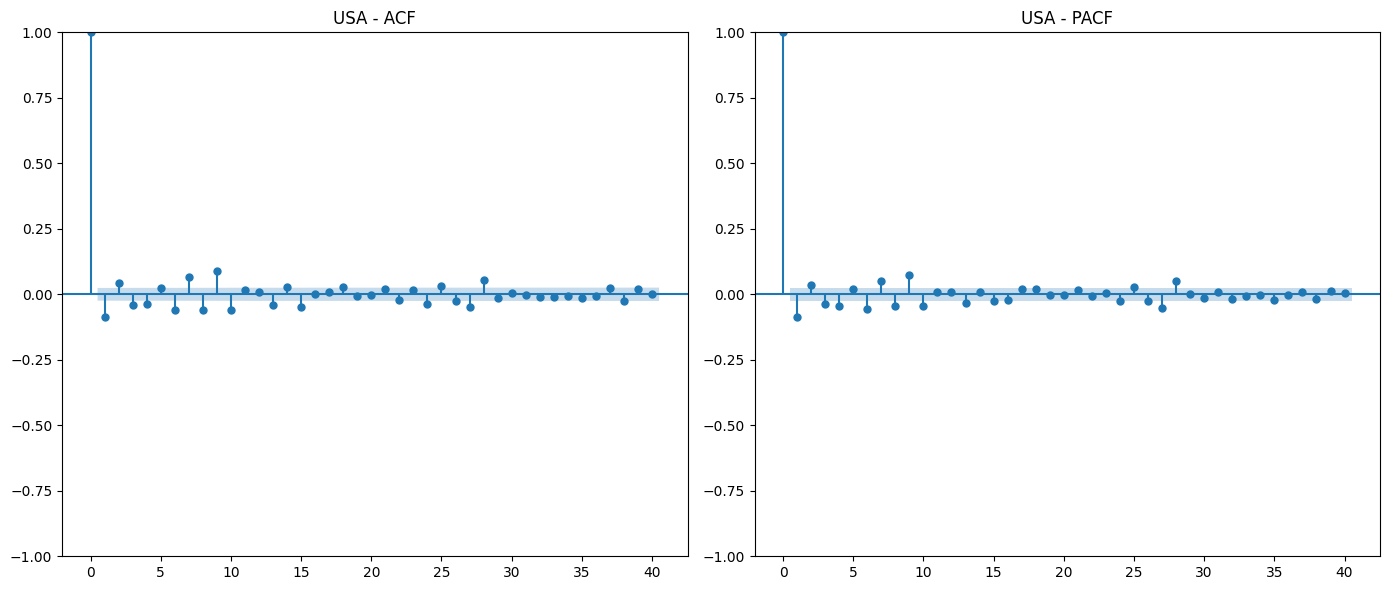


📊 Ljung-Box Test for USA
       lb_stat     lb_pvalue
10  230.001222  8.584102e-44
20  269.233801  1.474226e-45
30  334.238430  4.372695e-53
❌ Autocorrelation detected (reject H0)


In [53]:
# Prepare series
usa_ts = prepare_ts(stock_data['USA'])

# Plot ACF & PACF
plot_acf_pacf(usa_ts, 'USA')

# Apply differencing
usa_diff = difference_series(usa_ts, 'USA', order=1)

# Check ACF/PACF again on differenced series
plot_acf_pacf(usa_diff, 'USA')

# Ljung-Box Test
ljung_box_test(usa_diff, 'USA')
